In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Gage Height Locations

In [2]:
# path to scraped stream gauge height location data (.csv)
gage_height_locations_path = glob.glob('stream_gauges/gage_height*.csv')[0]

# path to directory containing scraped stream gauge height measurement data (.csv)
gage_height_data_paths = glob.glob(r"stream_gauges/gauge_height/*.csv")

In [3]:
# read data into dataframe
df_gageheight = pd.read_csv(gage_height_locations_path)

# drop first row (non-data)
df_gageheight.drop(index=0, inplace=True)

# cast latitude, longitude, and altitude to float
df_gageheight = df_gageheight.astype(dtype={'dec_lat_va':np.float32, 'dec_long_va':np.float32, 'alt_va': np.float32})

# drop unncessary columns
df_gageheight.drop(columns=['coord_acy_cd', 'alt_acy_va', 'alt_datum_cd', 'huc_cd', 'basin_cd', 'rt_bol'], inplace=True)

# rename columns
df_gageheight.rename(columns={'dec_lat_va':'lat', 'dec_long_va':'long', 'dec_coord_datum_cd':'datum','alt_va':'altitude'}, inplace=True)

# create dummy to indicate gage height/flood stage measurement at each location
df_gageheight['gh'] = 1

# initialize datetime columns for start and end dates of measurement records
df_gageheight['gh_start'] = pd.NaT
df_gageheight['gh_end'] = pd.NaT

# display first 5 rows of dataframe
df_gageheight.head()

,site_no,station_nm,lat,long,datum,altitude,gh,gh_start,gh_end
1,03207965,"GRAPEVINE CREEK NEAR PHYLLIS, KY",37.432606,-82.353760,NAD83,797.190002,1,NaT,NaT
2,03208000,"LEVISA FORK BELOW FISHTRAP DAM NEAR MILLARD, KY",37.425938,-82.412369,NAD83,599.159973,1,NaT,NaT
3,03209300,"RUSSELL FORK AT ELKHORN CITY, KY",37.303997,-82.342926,NAD83,773.000000,1,NaT,NaT
4,03209310,"ELKHORN LAKE AT JENKINS, KY",37.168354,-82.635063,NAD83,1573.060059,1,NaT,NaT
5,03209325,"ELKHORN CREEK AT BURDINE, KY",37.187832,-82.604568,NAD83,NaN,1,NaT,NaT


In [4]:
# iterate through all data .csv files and get start and end dates for measurement records
for csv in gage_height_data_paths:
    
    # read csv file for specific stream gauge
    df_temp = pd.read_csv(csv, low_memory=False, dtype={'site_no':'string'})

    # get stream gauge id
    gage = df_temp.iloc[0,1]

    # get date of earliest recorded data at stream gauge
    start_date = pd.to_datetime(df_temp.iloc[0,2], errors='coerce')

    # get date of last recorded data at stream gauge
    end_date = pd.to_datetime(df_temp.iloc[-1,2], errors='coerce')

    # add start and end dates to main dataframe
    df_gageheight.loc[df_gageheight['site_no'] == gage, 'gh_start'] = start_date
    df_gageheight.loc[df_gageheight['site_no'] == gage, 'gh_end'] = end_date

In [5]:
# create timedelta for timespan of data collection
df_gageheight['gh_diff'] = df_gageheight['gh_end'] - df_gageheight['gh_start']

# sort dataframe by stream gauge id
df_gageheight.sort_values('site_no', inplace=True)

# reset index
df_gageheight.reset_index(inplace=True, drop=True)

# display first five rows of dataframe
df_gageheight.head()

,site_no,station_nm,lat,long,datum,altitude,gh,gh_start,gh_end,gh_diff
0,03207965,"GRAPEVINE CREEK NEAR PHYLLIS, KY",37.432606,-82.353760,NAD83,797.190002,1,2007-10-01 01:00:00,2024-04-03 01:00:00,6029 days 00:00:00
1,03208000,"LEVISA FORK BELOW FISHTRAP DAM NEAR MILLARD, KY",37.425938,-82.412369,NAD83,599.159973,1,2008-07-31 11:00:00,2024-04-03 01:00:00,5724 days 14:00:00
2,03209300,"RUSSELL FORK AT ELKHORN CITY, KY",37.303997,-82.342926,NAD83,773.000000,1,2008-10-10 10:00:00,2017-10-03 16:30:00,3280 days 06:30:00
3,03209310,"ELKHORN LAKE AT JENKINS, KY",37.168354,-82.635063,NAD83,1573.060059,1,2023-12-07 13:45:00,2024-04-03 01:00:00,117 days 11:15:00
4,03209325,"ELKHORN CREEK AT BURDINE, KY",37.187832,-82.604568,NAD83,NaN,1,2024-01-31 14:45:00,2024-04-03 01:00:00,62 days 10:15:00


In [6]:
# show dtype and null/non-null information
df_gageheight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   site_no     252 non-null    object         
 1   station_nm  252 non-null    object         
 2   lat         252 non-null    float32        
 3   long        252 non-null    float32        
 4   datum       252 non-null    object         
 5   altitude    232 non-null    float32        
 6   gh          252 non-null    int64          
 7   gh_start    252 non-null    datetime64[ns] 
 8   gh_end      252 non-null    datetime64[ns] 
 9   gh_diff     252 non-null    timedelta64[ns]
dtypes: datetime64[ns](2), float32(3), int64(1), object(3), timedelta64[ns](1)
memory usage: 16.9+ KB


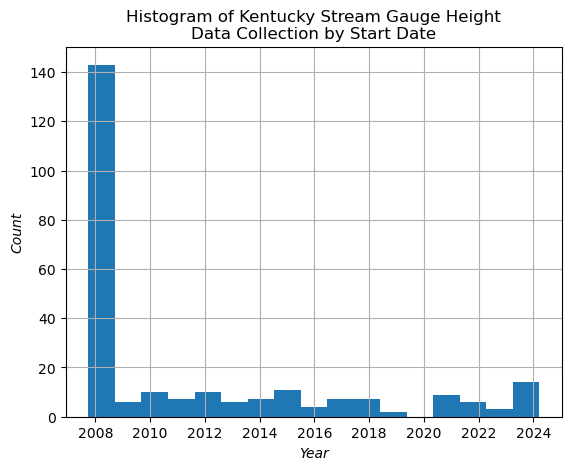

In [7]:
# show histogram of data collection start dates for gage height/flood stage...
# define bins as years from start to end
bins = df_gageheight['gh_start'].max().year - df_gageheight['gh_start'].min().year

# plot histogram
df_gageheight['gh_start'].hist(bins=bins)

# add title and labels
plt.title('Histogram of Kentucky Stream Gauge Height\nData Collection by Start Date')
plt.ylabel('Count', style='italic')
plt.xlabel('Year', style='italic')

plt.show()

# Streamflow / Discharge

In [7]:
# path to streamflow location .csv file
streamflow_path = glob.glob('stream_gauges/streamflow*.csv')[0]

# path to directory containing streamflow data measurement files for each stream gauge
streamflow_data_paths = glob.glob(r"stream_gauges/Streamflow/*.csv")

In [8]:
# read streamflow location .csv file
df_streamflow = pd.read_csv(streamflow_path)

# drop first row (non-date)
df_streamflow.drop(index=0, inplace=True)

# cast latitude, longitude, altitude to float
df_streamflow = df_streamflow.astype(dtype={'dec_lat_va':np.float32, 'dec_long_va':np.float32, 'alt_va': np.float32})

# drop unnecessary columns
df_streamflow.drop(columns=['coord_acy_cd', 'alt_acy_va', 'alt_datum_cd', 'huc_cd', 'basin_cd', 'rt_bol'], inplace=True)

# rename columns
df_streamflow.rename(columns={'dec_lat_va':'lat', 'dec_long_va':'long', 'dec_coord_datum_cd':'datum','alt_va':'altitude'}, inplace=True)

# create dummy variable indicating streamflow is measured at gauge
df_streamflow['sf'] = 1

# initialize datetime columns for recording earliest and latest measurments recorded
df_streamflow['sf_start'] = pd.NaT
df_streamflow['sf_end'] = pd.NaT

# display first 5 rows of dataframe
df_streamflow.head()

,site_no,station_nm,lat,long,datum,altitude,sf,sf_start,sf_end
1,03207965,"GRAPEVINE CREEK NEAR PHYLLIS, KY",37.432606,-82.353760,NAD83,797.190002,1,NaT,NaT
2,03209410,"RUSSELL FORK AT CEDARVILLE, KY",37.312954,-82.359558,NAD83,743.400024,1,NaT,NaT
3,03209500,"LEVISA FORK AT PIKEVILLE, KY",37.464268,-82.526260,NAD83,631.260010,1,NaT,NaT
4,03209800,"LEVISA FORK AT PRESTONSBURG, KY",37.670929,-82.777107,NAD83,587.380005,1,NaT,NaT
5,03210000,"JOHNS CREEK NEAR META, KY",37.567043,-82.457924,NAD83,714.520020,1,NaT,NaT


In [9]:
# iterate through all streamflow data .csv files for each stream gauge
for csv in streamflow_data_paths:
    
    # read streamflow data for specific gauge
    df_temp = pd.read_csv(csv, low_memory=False, dtype={'site_no':'string'})
    
    # get stream gauge id
    gage = df_temp.iloc[0,1]

    # get date of earliest measurement
    start_date = pd.to_datetime(df_temp.iloc[0,2], errors='coerce')

    # get date of latest measurement
    end_date = pd.to_datetime(df_temp.iloc[-1,2], errors='coerce')

    # add dates to streamflow dataframe
    df_streamflow.loc[df_streamflow['site_no'] == gage, 'sf_start'] = start_date
    df_streamflow.loc[df_streamflow['site_no'] == gage, 'sf_end'] = end_date

In [10]:
# create timedelta for timespan of data collection
df_streamflow['sf_diff'] = df_streamflow['sf_end'] - df_streamflow['sf_start']

# sort streamflow dataframe by start date from earliest to latest
df_streamflow.sort_values('sf_start', inplace=True)

# reset index
df_streamflow.reset_index(inplace=True, drop=True)

# display first five rows of dataframe
df_streamflow.head()

,site_no,station_nm,lat,long,datum,altitude,sf,sf_start,sf_end,sf_diff
0,03404000,"CUMBERLAND RIVER AT WILLIAMSBURG, KY",36.743416,-84.156044,NAD83,891.020020,1,1973-03-15 01:00:00,2024-04-03 01:00:00,18647 days 00:00:00
1,03210000,"JOHNS CREEK NEAR META, KY",37.567043,-82.457924,NAD83,714.520020,1,1974-01-18 00:00:00,2024-04-03 01:00:00,18338 days 01:00:00
2,03403910,"CLEAR FORK AT SAXTON, KY",36.633972,-84.111595,NAD83,921.429993,1,1975-02-09 00:00:00,2024-04-03 01:00:00,17951 days 01:00:00
3,03403500,"CUMBERLAND RIVER AT BARBOURVILLE, KY",36.862309,-83.887428,NAD83,942.489990,1,1984-03-17 01:00:00,2005-09-30 23:30:00,7867 days 22:30:00
4,03410500,"SOUTH FORK CUMBERLAND RIVER NEAR STEARNS, KY",36.627022,-84.533272,NAD83,765.359985,1,1984-03-31 01:00:00,2023-12-09 14:30:00,14497 days 13:30:00


In [11]:
# print dtype and null/non-null information
df_streamflow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   site_no     228 non-null    object         
 1   station_nm  228 non-null    object         
 2   lat         228 non-null    float32        
 3   long        228 non-null    float32        
 4   datum       228 non-null    object         
 5   altitude    193 non-null    float32        
 6   sf          228 non-null    int64          
 7   sf_start    228 non-null    datetime64[ns] 
 8   sf_end      228 non-null    datetime64[ns] 
 9   sf_diff     228 non-null    timedelta64[ns]
dtypes: datetime64[ns](2), float32(3), int64(1), object(3), timedelta64[ns](1)
memory usage: 15.3+ KB


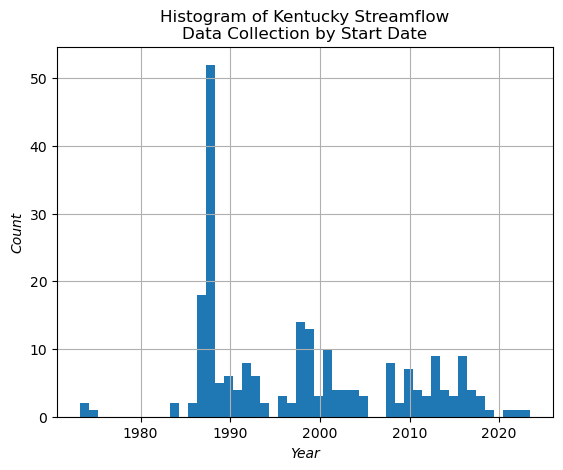

In [14]:
# plot histogram of distribution of earliest measurement dates for streamflow...
# define bins by year from start to finish
bins = df_streamflow['sf_start'].max().year - df_streamflow['sf_start'].min().year

# plot histogram
df_streamflow['sf_start'].hist(bins=bins)

# add title and labels
plt.title('Histogram of Kentucky Streamflow\nData Collection by Start Date')
plt.ylabel('Count', style='italic')
plt.xlabel('Year', style='italic')

plt.show()

# Merge Gage Height & Streamflow

In [12]:
# merge gauge height/flood stage with streamflow/discharge using stream gauge id
df_locations = pd.merge(left=df_gageheight, right=df_streamflow, how='outer', on='site_no', suffixes=['', '_sf'])

# show dtype and null/non-null information
df_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   site_no        295 non-null    object         
 1   station_nm     252 non-null    object         
 2   lat            252 non-null    float32        
 3   long           252 non-null    float32        
 4   datum          252 non-null    object         
 5   altitude       232 non-null    float32        
 6   gh             252 non-null    float64        
 7   gh_start       252 non-null    datetime64[ns] 
 8   gh_end         252 non-null    datetime64[ns] 
 9   gh_diff        252 non-null    timedelta64[ns]
 10  station_nm_sf  228 non-null    object         
 11  lat_sf         228 non-null    float32        
 12  long_sf        228 non-null    float32        
 13  datum_sf       228 non-null    object         
 14  altitude_sf    193 non-null    float32        
 15  sf    

In [13]:
# clean merged dataframe...
# set indicator values to 0 if no measurement exists after merging
df_locations.loc[df_locations['gh']!=1, 'gh'] = 0     # gage height
df_locations.loc[df_locations['sf']!=1, 'sf'] = 0     # streamflow

# cast indicator variables to integer
df_locations[['gh','sf']] = df_locations[['gh','sf']].astype(np.int32)

# get indices/rows of gageheight locations/rows with missing values...
# (from gage height and streamflow dataframes not matching up exactly during merge)

# missing station name indices
nan_indices = df_locations[df_locations['station_nm'].isna()].index.values

# transfer station name from streamflow dataframe to correct column in merged dataframe
df_locations.loc[nan_indices, 'station_nm'] = df_locations.loc[nan_indices, 'station_nm_sf']

# transfer latitude
df_locations.loc[nan_indices, 'lat'] = df_locations.loc[nan_indices, 'lat_sf']

# transfer longitude
df_locations.loc[nan_indices, 'long'] = df_locations.loc[nan_indices, 'long_sf']

# transfer datum
df_locations.loc[nan_indices, 'datum'] = df_locations.loc[nan_indices, 'datum_sf']

# transfer altitude
df_locations.loc[nan_indices, 'altitude'] = df_locations.loc[nan_indices, 'altitude_sf']

# drop extra columns from merge
df_locations.drop(columns=['station_nm_sf', 'lat_sf', 'long_sf', 'datum_sf', 'altitude_sf'], inplace=True)

# show dtype and null/non-null information
df_locations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   site_no     295 non-null    object         
 1   station_nm  295 non-null    object         
 2   lat         295 non-null    float32        
 3   long        295 non-null    float32        
 4   datum       295 non-null    object         
 5   altitude    241 non-null    float32        
 6   gh          295 non-null    int32          
 7   gh_start    252 non-null    datetime64[ns] 
 8   gh_end      252 non-null    datetime64[ns] 
 9   gh_diff     252 non-null    timedelta64[ns]
 10  sf          295 non-null    int32          
 11  sf_start    228 non-null    datetime64[ns] 
 12  sf_end      228 non-null    datetime64[ns] 
 13  sf_diff     228 non-null    timedelta64[ns]
dtypes: datetime64[ns](4), float32(3), int32(2), object(3), timedelta64[ns](2)
memory usage: 26.6+ KB


In [14]:
# display first 5 rows of cleaned dataframe
df_locations.head()

,site_no,station_nm,lat,long,datum,altitude,gh,gh_start,gh_end,gh_diff,sf,sf_start,sf_end,sf_diff
0,03207965,"GRAPEVINE CREEK NEAR PHYLLIS, KY",37.432606,-82.353760,NAD83,797.190002,1,2007-10-01 01:00:00,2024-04-03 01:00:00,6029 days 00:00:00,1,1989-04-25,2024-04-03 01:00:00,12762 days 01:00:00
1,03208000,"LEVISA FORK BELOW FISHTRAP DAM NEAR MILLARD, KY",37.425938,-82.412369,NAD83,599.159973,1,2008-07-31 11:00:00,2024-04-03 01:00:00,5724 days 14:00:00,0,NaT,NaT,NaT
2,03209300,"RUSSELL FORK AT ELKHORN CITY, KY",37.303997,-82.342926,NAD83,773.000000,1,2008-10-10 10:00:00,2017-10-03 16:30:00,3280 days 06:30:00,0,NaT,NaT,NaT
3,03209310,"ELKHORN LAKE AT JENKINS, KY",37.168354,-82.635063,NAD83,1573.060059,1,2023-12-07 13:45:00,2024-04-03 01:00:00,117 days 11:15:00,0,NaT,NaT,NaT
4,03209325,"ELKHORN CREEK AT BURDINE, KY",37.187832,-82.604568,NAD83,NaN,1,2024-01-31 14:45:00,2024-04-03 01:00:00,62 days 10:15:00,0,NaT,NaT,NaT


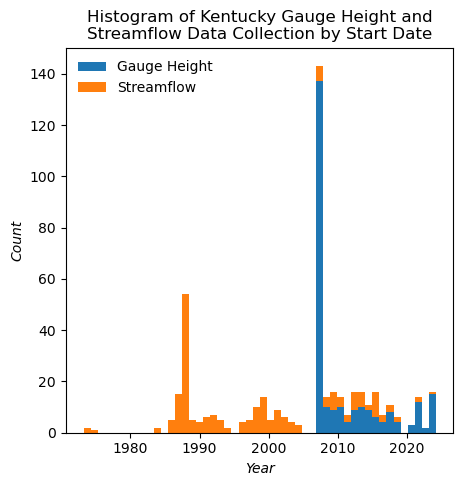

In [18]:
# plot histogram of data measurement start dates...
# define figure and axes objects, and figure size
fig, ax = plt.subplots(figsize=(5,5))

# define bins  as years between max and min start dates
bins = df_streamflow['sf_start'].max().year - df_streamflow['sf_start'].min().year

# plot histogram of gage height/flood stage & streamflow/discharge
ax.hist(df_locations[['gh_start','sf_start']],
        bins=bins, 
        histtype='barstacked', 
        label=['Gauge Height','Streamflow'])

# legend, title, and labels
plt.legend(frameon=False)
plt.title('Histogram of Kentucky Gauge Height and\nStreamflow Data Collection by Start Date')
plt.xlabel('Year', style='italic')
plt.ylabel('Count', style='italic')

plt.show()

# Spatial Join with Watersheds

## Load Geodataframes

In [15]:
# convert dataframe to geodataframe with latitude and longitude as geometry and crs as nad83
gdf_locations = gpd.GeoDataFrame(df_locations, 
                                 geometry=[Point(xy) for xy in zip(df_locations['long'], df_locations['lat'])], 
                                 crs='EPSG:4269')

# display dtype info of geodataframe
gdf_locations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 295 entries, 0 to 294
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   site_no     295 non-null    object         
 1   station_nm  295 non-null    object         
 2   lat         295 non-null    float32        
 3   long        295 non-null    float32        
 4   datum       295 non-null    object         
 5   altitude    241 non-null    float32        
 6   gh          295 non-null    int32          
 7   gh_start    252 non-null    datetime64[ns] 
 8   gh_end      252 non-null    datetime64[ns] 
 9   gh_diff     252 non-null    timedelta64[ns]
 10  sf          295 non-null    int32          
 11  sf_start    228 non-null    datetime64[ns] 
 12  sf_end      228 non-null    datetime64[ns] 
 13  sf_diff     228 non-null    timedelta64[ns]
 14  geometry    295 non-null    geometry       
dtypes: datetime64[ns](4), float32(3), geometry(1), in

In [16]:
# bring in huc10 watershed boundary shapefile as geodataframe...
# path to shapefile that has been cut to Kentucky in previous notebook
input_watersheds_path = r'nhd/ky_huc10.shp'

# read shapefile into geodataframe
gdf_watersheds = gpd.read_file(input_watersheds_path)

# display dtype info of geodataframe
gdf_watersheds.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   loaddate  249 non-null    object  
 1   areasqkm  249 non-null    float64 
 2   huc10     249 non-null    object  
 3   name      249 non-null    object  
 4   geometry  249 non-null    geometry
dtypes: float64(1), geometry(1), object(3)
memory usage: 9.9+ KB


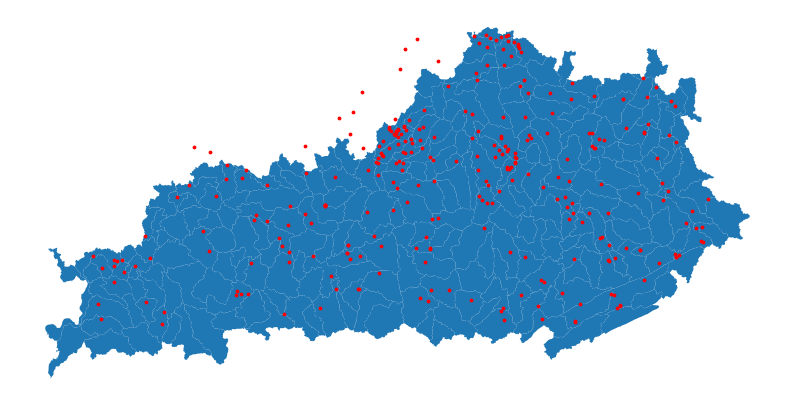

In [17]:
# plot to verify both datasets align...
fig, ax = plt.subplots(figsize=(10,7))
gdf_watersheds.plot(ax=ax)
gdf_locations.plot(ax=ax, color='yellow', linewidth=0.25, edgecolor='k', markersize=5)
ax.set_axis_off()
plt.show()

## Spatial Join

In [18]:
# perform spatial join of locations with watersheds (see plot above that several locations lie outside of area of interest and won't be in the join geodataframe)
gdf = gpd.sjoin(left_df=gdf_locations, right_df=gdf_watersheds[['geometry', 'huc10', 'name', 'areasqkm']], predicate='within')

# drop column
gdf.drop(columns='index_right', inplace=True)

# rename columns
gdf.rename(columns={'name':'huc10_name', 'areasqkm':'huc10_area'}, inplace=True)

# display info of joined geodataframe
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 280 entries, 0 to 294
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype          
---  ------      --------------  -----          
 0   site_no     280 non-null    object         
 1   station_nm  280 non-null    object         
 2   lat         280 non-null    float32        
 3   long        280 non-null    float32        
 4   datum       280 non-null    object         
 5   altitude    227 non-null    float32        
 6   gh          280 non-null    int32          
 7   gh_start    237 non-null    datetime64[ns] 
 8   gh_end      237 non-null    datetime64[ns] 
 9   gh_diff     237 non-null    timedelta64[ns]
 10  sf          280 non-null    int32          
 11  sf_start    216 non-null    datetime64[ns] 
 12  sf_end      216 non-null    datetime64[ns] 
 13  sf_diff     216 non-null    timedelta64[ns]
 14  geometry    280 non-null    geometry       
 15  huc10       280 non-null    object         
 16  huc10

In [19]:
# several gauges outside of area of interest (see plot above), so drop these from the original dataframe...
# index of gauges that lie within watershed boundaries
sjoin_gauges = gdf.index

# reset index of geodataframe for locations...
gdf.reset_index(drop=True, inplace=True)

## Save files

In [20]:
# save cleaned and merged dataframe...
# path to save file
output_path = r'stream_gauges/KY_StreamGaugeLocations.csv'

# drop geometry column from geodataframe then save as csv file
gdf.drop(columns='geometry').to_csv(output_path, index=False)

In [21]:
# set directory to save geodataframe as shapefile
# output_dir = r'/Users/Matthew/Documents/GitHub/Watershed_Clustering/Datasets/stream_gauges'
output_path = r'stream_gauges/KY_StreamGaugeLocations.shp'

# convert all datetime columns to string format...
# (ESRI shapefile format does not support datetime)
# iterate over columns and dtypes in geodataframe
for col, dtype in gdf.dtypes.items():

    # handle datetime and timedelta dtypes
    if (dtype == 'datetime64[ns]') | (dtype == 'timedelta64[ns]'):

        # convert to string
        gdf[col] = gdf[col].astype(str)
        
# save geodataframe as shapefile to path
gdf.to_file(output_path, index=False)

In [22]:
# save shapefile version in utm crs...
# path to save new shapefile
output_path = r'stream_gauges/KY_StreamGaugeLocations_26916.shp'

# reproject to utm zone 16 north
gdf_reprojected = gdf.to_crs('EPSG:26916')

# save new shapefile
gdf_reprojected.to_file(output_path)